In [1]:
import pandas as pd
# import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import datetime

sns.set()

DATA_DIR = Path('../data/')
pd.set_option('max_columns', 999)

# Loading data

In [2]:
# Extract list of dates, list of calendar filepaths, list of listing filepaths
dates = [re.findall(r'_20(\d{2})-(\d{2})-(\d{2}).*', cal_file.stem)[0] for cal_file in DATA_DIR.iterdir() if 'calendar' in cal_file.stem]
cal_files = [cal_file for cal_file in DATA_DIR.iterdir() if 'calendar' in cal_file.stem]
listing_files = [listing_file for listing_file in DATA_DIR.iterdir() if 'listing' in listing_file.stem]

In [3]:
list(enumerate(dates))

[(0, ('17', '02', '02')),
 (1, ('16', '09', '02')),
 (2, ('16', '12', '03')),
 (3, ('17', '04', '02')),
 (4, ('17', '10', '02')),
 (5, ('17', '09', '02')),
 (6, ('18', '05', '09')),
 (7, ('16', '11', '02')),
 (8, ('16', '05', '02')),
 (9, ('17', '03', '02')),
 (10, ('18', '01', '10')),
 (11, ('16', '08', '02')),
 (12, ('17', '05', '02')),
 (13, ('17', '01', '01')),
 (14, ('17', '08', '02')),
 (15, ('16', '06', '02')),
 (16, ('18', '03', '04')),
 (17, ('16', '04', '03')),
 (18, ('18', '02', '02')),
 (19, ('16', '10', '01')),
 (20, ('17', '06', '02')),
 (21, ('17', '12', '02')),
 (22, ('16', '07', '02')),
 (23, ('17', '11', '01')),
 (24, ('18', '04', '06')),
 (25, ('17', '07', '02'))]

# Pipeline for extracting data for events

In [4]:
def get_cal_data(event_start, event_end, dates, cal_files, listing_files):
    final_cal = None
    for date, cal, listing in zip(dates, cal_files, listing_files):
        data = pd.read_csv(cal, compression='gzip')
        listing_type = pd.read_csv(listing, compression='gzip')[['id', 'room_type']]
        
        data = pd.merge(data, listing_type, left_on='listing_id', right_on='id', how='left')
        data['date'] = pd.to_datetime(data['date'])
        data['price'] = (
            data
            .loc[:, 'price']
            .str.extract(r'\$(.*)', expand=False)
            .str.replace(r',', '')
            .astype(np.float_)
        )
        subset = data[(data['date'] >= event_start) & (data['date'] <= event_end)]
        subset['scraped'] = pd.Timestamp(2000 + int(date[0]), int(date[1]), int(date[2]))
        if final_cal is None:
            final_cal = subset
        else:
            final_cal = pd.concat([final_cal, subset])
    
    del data
    return final_cal

In [5]:
def plot_data(cal_data, bins, labels, title):
    room_types = cal_data['room_type'].unique()
    n_types = len(room_types)
    
    plt.figure(figsize=(25, 7))
    for i, room_type in enumerate(room_types):
        prices = (
            cal_data[cal_data['room_type'] == room_type]
            .groupby(["Listing period", "available"])
            .size()
            .reset_index()
            .rename(columns={0:'Value'})
            .pivot_table(values='Value', index='Listing period', columns='available')
        )
        
#         prices['Listing period'] = pd.cut(prices['date'], bins=bins, labels=labels)
        
        return prices
                
#         plt.subplot(1, n_types, i + 1)
#         sns.lineplot(data=prices, x='scraped', y='price', hue='Listing period', ci=None)
#         plt.xlabel('Booking Date')
#         plt.ylabel('Price')
#         plt.title(title + ', ' + room_type)

In [6]:
def replace_available(cal_data):
    return_data = cal_data.copy()
    return_data["available"] = return_data["available"].replace('t', True)
    return_data["available"] = return_data["available"].replace('f', False)
    return return_data

def listing_count(data, bins, labels):
    data['Listing period'] = pd.cut(data['date'], bins=bins, labels=labels)
    data = (
        data
        .groupby(["Listing period", "available"]).size()
        .reset_index()
        .rename(columns={0:'Value'})
        .pivot_table(values='Value', index='Listing period', columns='available')
    )
    data.columns = ["not available", "available"]
    
    return data

# Dreamforce

In [7]:
DREAMFORCE_START = pd.Timestamp(2017, 10, 31)
DREAMFORCE_END = pd.Timestamp(2017, 11, 15)

dreamforce_cal = get_cal_data(DREAMFORCE_START, DREAMFORCE_END, dates[8:20], cal_files[8:20], listing_files[8:20])

/Users/valerietan/miniconda2/envs/data100/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/valerietan/miniconda2/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
dreamforce_cal.head()
dreamforce_cal.shape

(569344, 7)

In [14]:
dreamforce_avail = replace_available(dreamforce_cal)
dreamforce_avail["room_type"].unique()

dreamforce_entire = dreamforce_avail[dreamforce_avail["room_type"] == 'Entire home/apt']
dreamforce_private = dreamforce_avail[dreamforce_avail["room_type"] == 'Private room']
dreamforce_shared = dreamforce_avail[dreamforce_avail["room_type"] == 'Shared room']

bins = [DREAMFORCE_START, pd.Timestamp(2017, 11, 3), pd.Timestamp(2017, 11, 9), DREAMFORCE_END]
labels = ['Before conference', 'During conference', 'After conference']

dreamforce_entire['Listing period'] = pd.cut(dreamforce_entire['date'], bins=bins, labels=labels)
      
dreamforce_entire = (
    dreamforce_entire
    .groupby(["scraped", "Listing period", "available"]).size()
    .reset_index()
    .rename(columns={0:'Value'})
    .pivot_table(values='Value', index='scraped', columns=['Listing period', 'available'])
)

dreamforce_entire.head()

/Users/valerietan/miniconda2/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Listing period Before conference       During conference        \
available                  False True              False True    
scraped                                                          
2017-01-01                  8154  4332             16237  8735   
2017-03-02                  2724  2400              5369  4879   
2017-05-02                  8582  3901             17328  7638   
2017-08-02                 10105  4379             22020  6948   

Listing period After conference        
available                 False True   
scraped                                
2017-01-01                16201  8771  
2017-03-02                 5324  4924  
2017-05-02                16991  7975  
2017-08-02                19628  9340

In [16]:
dreamforce_entire.head()

Listing period Before conference       During conference        \
available                  False True              False True    
scraped                                                          
2017-01-01                  8154  4332             16237  8735   
2017-03-02                  2724  2400              5369  4879   
2017-05-02                  8582  3901             17328  7638   
2017-08-02                 10105  4379             22020  6948   

Listing period After conference        
available                 False True   
scraped                                
2017-01-01                16201  8771  
2017-03-02                 5324  4924  
2017-05-02                16991  7975  
2017-08-02                19628  9340

In [17]:
dreamforce_avail = replace_available(dreamforce_cal)
dreamforce_avail["room_type"].unique()

dreamforce_entire = dreamforce_avail[dreamforce_avail["room_type"] == 'Entire home/apt']
dreamforce_private = dreamforce_avail[dreamforce_avail["room_type"] == 'Private room']
dreamforce_shared = dreamforce_avail[dreamforce_avail["room_type"] == 'Shared room']

bins = [DREAMFORCE_START, pd.Timestamp(2017, 11, 3), pd.Timestamp(2017, 11, 9), DREAMFORCE_END]
labels = ['Before conference', 'During conference', 'After conference']

dreamforce_entire['Listing period'] = pd.cut(dreamforce_entire['date'], bins=bins, labels=labels)

dreamforce_tmp = (
    dreamforce_entire
    .groupby(["scraped", "Listing period"])['available'].mean()
#     .reset_index()
#     .rename(columns={0:'Value'})
#     .pivot_table(values='Value', index='scraped', columns=['Listing period', 'available'])
)


/Users/valerietan/miniconda2/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [23]:
tmp2 = dreamforce_tmp.reset_index().pivot_table(values='available', index='scraped', columns='Listing period')

In [24]:
sns.lineplot(tmp2.index, )

DatetimeIndex(['2017-01-01', '2017-03-02', '2017-05-02', '2017-08-02'], dtype='datetime64[ns]', name='scraped', freq=None)

In [101]:
# plot_data(dreamforce_cal, 
#           bins=[DREAMFORCE_START, pd.Timestamp(2017, 11, 3), 
#                 pd.Timestamp(2017, 11, 9), DREAMFORCE_END],
#           labels=['Before conference', 'During conference', 'After conference'],
#           title='Dreamforce')
# plt.savefig('dreamforce.png')

# Christmas / New Years

In [7]:
CHRISTMAS_START = pd.Timestamp(2017, 12, 18)
CHRISTMAS_END = pd.Timestamp(2018, 1, 5)

christmas_cal = get_cal_data(CHRISTMAS_START, CHRISTMAS_END, dates[9:21], cal_files[9:21], listing_files[9:21])

/Users/valerietan/miniconda2/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/valerietan/miniconda2/envs/data100/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


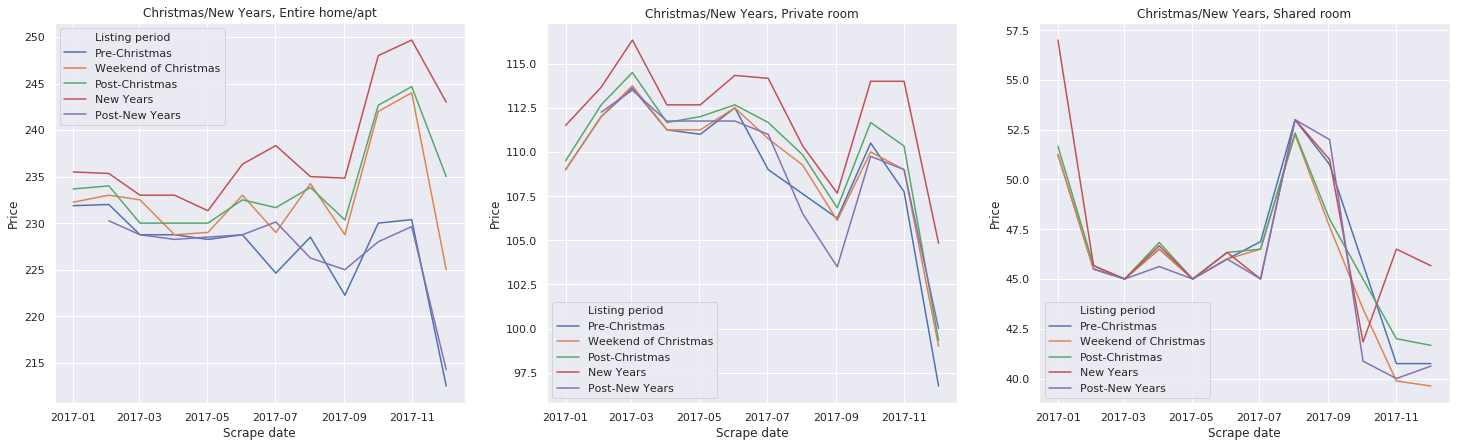

In [113]:
plot_data(christmas_cal, 
          bins=[CHRISTMAS_START, pd.Timestamp(2017, 12, 22), 
                pd.Timestamp(2017, 12, 26), pd.Timestamp(2017, 12, 29),
                pd.Timestamp(2018, 1, 1), CHRISTMAS_END],
          labels=['Pre-Christmas', 'Weekend of Christmas', 'Post-Christmas', 'New Years', 'Post-New Years'],
          title='Christmas/New Years')
plt.savefig('christmas.png')

# SF Pride

In [100]:
PRIDE_START = pd.Timestamp(2017, 6, 18)
PRIDE_END = pd.Timestamp(2017, 6, 30)

pride_cal = get_cal_data(PRIDE_START, PRIDE_END, dates[3:15], cal_files[3:15], listing_files[3:15])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


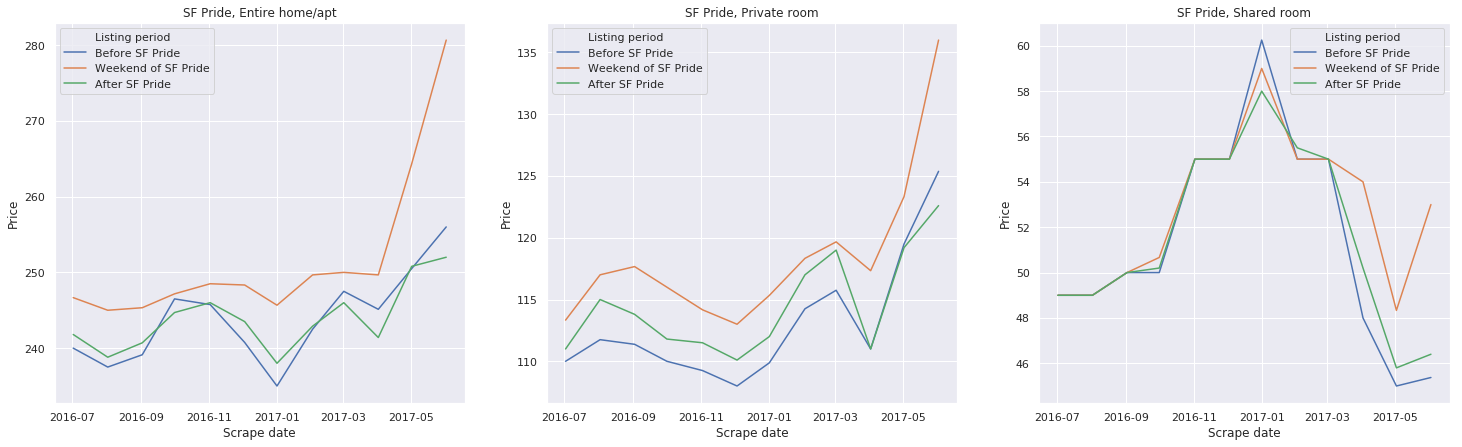

In [114]:
plot_data(pride_cal, 
          bins=[PRIDE_START, pd.Timestamp(2017, 6, 22), 
                pd.Timestamp(2017, 6, 25), PRIDE_END],
          labels=['Before SF Pride', 'Weekend of SF Pride', 'After SF Pride'],
          title='SF Pride')
plt.savefig('pride.png')

# Outside Lands

In [106]:
OSL_START = pd.Timestamp(2017, 8, 7)
OSL_END = pd.Timestamp(2017, 8, 18)

osl_cal = get_cal_data(OSL_START, OSL_END, dates[5:17], cal_files[5:17], listing_files[5:17])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


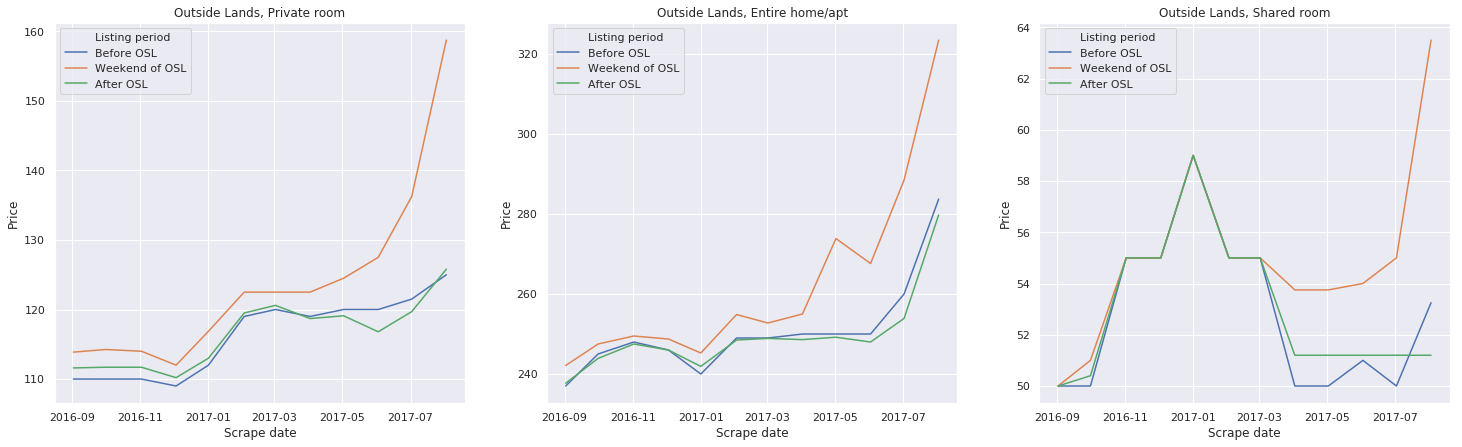

In [115]:
plot_data(osl_cal, 
          bins=[OSL_START, pd.Timestamp(2017, 8, 9), 
                pd.Timestamp(2017, 8, 13), OSL_END],
          labels=['Before OSL', 'Weekend of OSL', 'After OSL'],
          title='Outside Lands')
plt.savefig('osl.png')

# Independence Day

In [110]:
JULY4_START = pd.Timestamp(2017, 6, 26)
JULY4_END = pd.Timestamp(2017, 7, 7)

july4_cal = get_cal_data(JULY4_START, JULY4_END, dates[3:15], cal_files[3:15], listing_files[3:15])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


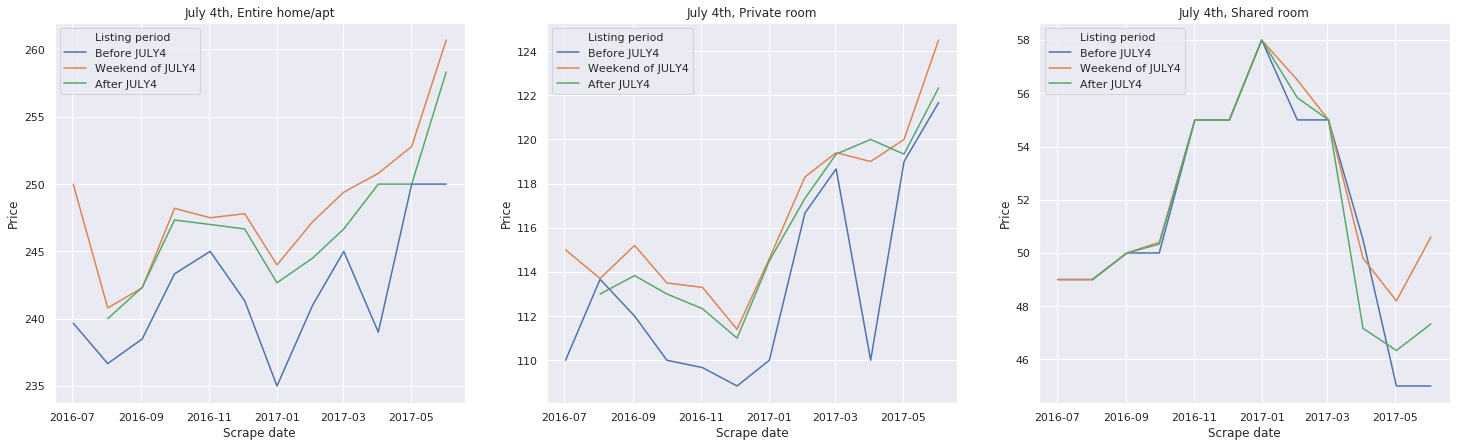

In [116]:
plot_data(july4_cal, 
          bins=[JULY4_START, pd.Timestamp(2017, 6, 29), 
                pd.Timestamp(2017, 7, 4), JULY4_END],
          labels=['Before JULY4', 'Weekend of JULY4', 'After JULY4'],
          title='July 4th')
plt.savefig('july4.png')

# Neighborhods

In [75]:
neighborhoods = gpd.read_file('../data/neighbourhoods.geojson')

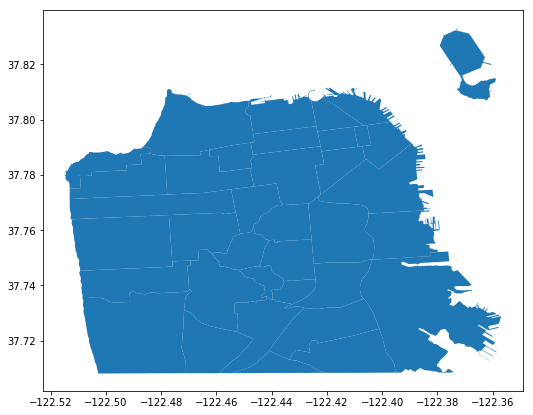

In [79]:
fig, ax = plt.subplots(figsize=(10, 7))
neighborhoods.plot(ax=ax)

In [80]:
neighborhoods

,neighbourhood,neighbourhood_group,geometry
0,Seacliff,None,"(POLYGON ((-122.484089 37.78791, -122.484346 3..."
1,Haight Ashbury,None,"(POLYGON ((-122.435964 37.769038, -122.436851 ..."
2,Outer Mission,None,"(POLYGON ((-122.454284 37.708222, -122.45456 3..."
3,Downtown/Civic Center,None,"(POLYGON ((-122.408912 37.790132, -122.408797 ..."
4,Diamond Heights,None,"(POLYGON ((-122.435527 37.74146, -122.435632 3..."
5,Lakeshore,None,"(POLYGON ((-122.471051 37.708198, -122.472829 ..."
6,Russian Hill,None,"(POLYGON ((-122.420952 37.808967, -122.420614 ..."
7,Noe Valley,None,"(POLYGON ((-122.425578 37.756617, -122.424949 ..."
8,Inner Sunset,None,"(POLYGON ((-122.451436 37.758735, -122.451399 ..."
9,Treasure Island/YBI,None,"(POLYGON ((-122.373133 37.832253, -122.368622 ..."
